In [0]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps

**Гипотеза 7.** Две нормальные выборки, дисперсии не равны и не известны. Простая гипотеза против сложной. Другое название: проблема Беренса-Фишера

$$x_1, x_2, ..., x_n \ \sim \ \mathcal{N}(\theta_x, \sigma_x^2)$$
$$y_1, y_2, ..., y_m \ \sim \ \mathcal{N}(\theta_y, \sigma_y^2)$$
$$\delta = \theta_x - \theta_y$$

$$H_0: \delta=0 \  vs \  H_1:\  \delta\{\neq, <, >\}0$$

Будем использовать равномерный априор:
$$prior \ :\ \pi(\theta_x, \theta_y, \sigma_x^2, \sigma_y^2) \propto \sigma_x^{-2} \sigma_y^{-2}$$

Т.е.:

$$\theta_x,\theta_x, log \sigma_x, log \sigma_y \propto 1$$

Пусть $N, M$ - размеры выборок $X, Y$ соответственно

$S_x^2, S_y^2$ - выборочные дисперсии (смещенные)
$$posterior \ : \ \frac{\delta - (\overline{X} - \overline{Y})}{\sqrt{\frac{1}{N-1}S_x^2 + \frac{1}{M-1}S_y^2 }} \sim T$$

Пусть $\kappa = arctan \frac{S_x / \sqrt{N-1}}{S_y / \sqrt{M-1}}$

$T \sim BF(N-1, M-1, \kappa)$ - распределение Беренец-Фишера

**Для сведения к распределению Стьюдента воспользуемся аппроксимацией Патила:**

$f_1 = \frac{N-1}{N-3}sin^2\kappa + \frac{M-1}{M-3}cos^2\kappa$

$f_2 = \frac{(N-1)^2}{(N-3)^2(N-5)}sin^4\kappa + \frac{(M-1)^2}{(M-3)^2(M-5)}cos^4\kappa$

$b = 4 + \frac{f_1^2}{f_2}, \ a = \sqrt{\frac{f_1(b-2)}{b}}$

Тогда $T/a \sim T_b$ приближенно, где $T_b -$ распределение Стьюдента со степенью свободы $b$

Байесовский фактор для проверки гипотез:

$$B = \frac{P_0 / P_1}{\Pi_0 / \Pi_1}$$ где $\Pi_0, \Pi_1 - $ априорные вероятности первой гипотезы и альтернативы, $P_0, P_1$ - соответствующие апостериорные вероятности.

Методы проверки:

* Модификация $H_0$ : $\Theta_0 = \{(-\epsilon, \epsilon), (0, \epsilon), (-\epsilon, 0)\}$ в завивимости от альтернативы $\{\neq 0, >0, <0\}$

  плотность $p(x) = \int_{\Theta_0} q(t) p_t(x)dt + \int_{\Theta_1} q(t) p_t(x)dt $

  $P_0 = \frac{\int_{\Theta_0} q(t) p_t(x)dt}{p(x)} =  P_{posterior}(\Theta_0), P_1 = \frac{\int_{\Theta_1} q(t) p_t(x)dt}{p(x)} = P_{posterior}(\Theta_1)$

* Метод Линдли: ищем HDR - область наибольшей плотности

  $HDR = (posterior_{\alpha / 2}, posterior_{1 - \alpha / 2})$, т.к posterior - имеет распределение стьюдента со сдвигом и масштабом (приближенно)

  

In [0]:
class BehrensFisherProblem():
  def __init__(self, alternative="<>"):
    assert alternative in ('<>', '<', '>')

    self.alternative=alternative


  def get_posterior(self, X, Y):
    """
    return posterior distribution of delta
    calculate params of the posterior distribution using Patil approximation    
    """
    N = len(X)
    M = len(Y)
    self.loc = X.mean() - Y.mean() # параметер сдвига

    nominator = X.var() / (N - 1)
    denominator = Y.var() / (M - 1)

    kappa = np.arctan(np.sqrt(nominator / denominator))

    #Аппроксимация Патила:
    f1 = np.sin(kappa)**2 * (N-1)/(N-3) + np.cos(kappa)**2 * (M-1)/(M-3)
    f2 = np.sin(kappa)**4 * (N-1)**2/(N-3)**2/(N-5) + np.cos(kappa)**4 * (M-1)**2/(M-3)**2/(M-5)

    b = 4 + f1**2 / f2
    a = np.sqrt(f1*(b-2)/b)

    self.scale = np.sqrt(nominator + denominator) * a # подсчет масштаба распределения

    self.df = b  #степени свободы апостериорного распределения

    return sps.t(df=self.df, loc=self.loc, scale=self.scale)


  def test(self, X, Y, method='Lindley', level=0.05, pi0=0.5, eps=0.1):
    """
    params:
    X, Y : numpy arrays 
      two samples from normal distributions
    method : in (Lindley, modify, atom) -
      method of hypotheses testing
    level : float
      significance level
    pi0 : float
      prior probability of H0: delta = 0
    eps : float
      width of H0. used only if method==modify

    returns:
    if method==modify
      it returns dict : 
          posterior_df, 
          posterior_loc, 
          posterior_scale - params of the posterior distribution
          HDR,
          Posterior H0 prob - posterior probability P(H0),
          Posterior H1 prob - posterior probability P(H1),
          BF - Bayesian factor
    if mehthod==Lindley:
      dict:
        posterior_df, 
        posterior_loc, 
        posterior_scale - params of the posterior distribution
        HDR   
    """

    assert method in ('modify', 'Lindley', 'atom')
    assert 0 < level < 1

    self.level=level

    posterior = self.get_posterior(X, Y)

    pi1 = 1 - pi0 # prior probability P(H1)

    #считаем HDR
    if method=='Lindley' or method=='modify':
      HDR = (posterior.ppf(level/2.),
              posterior.ppf(1 - level/2.))
      
    if method=='modify':
      if self.alternative == '<>':
        p0 = posterior.cdf(eps) - posterior.cdf(-eps)
        p1 = 1 - p0

      if self.alternative == '<':
        p0 =  posterior.cdf(0) - posterior.cdf(-eps)
        p1 = posterior.cdf(-eps)

      if self.alternative == '>':
        p0 =  posterior.cdf(eps) - posterior.cdf(0)
        p1 = 1 - posterior.cdf(eps)

      denominator = p0 + p1
      p0 /= denominator
      p1 /= denominator
      
      # байесовский фактор
      BF = (p0 / p1) / (pi0 / pi1)

      return {"posterior_df":self.df, 
              "posterior_loc":self.loc, 
              "posterior_scale":self.scale, 
              "HDR":HDR,
              "Posterior H0 prob": p0,
              "Posterior H1 prob": p1,
              "BF" : (p0/p1)/(pi0/pi1)}

    if method=='Lindley':
      return {"posterior_df":self.df, 
              "posterior_loc":self.loc,
              "posterior_scale":self.scale, 
              "HDR":HDR}


Примеры работы:

$x_1, x_2, .., x_{30} \sim \mathcal{N}(1, 1^2)$

$y_1, y_2, .., y_{40} \sim \mathcal{N}(2, 2^2)$

$H_0 \ : \ \delta = 0 \ vs \ H_1 : \delta \neq 0$

In [22]:
# тестирование методом модификации

X = sps.norm(1, 1).rvs(30)
Y = sps.norm(2, 2).rvs(40)

stat_test = BehrensFisherProblem(alternative='<>')

stat_test.test(X, Y, method='modify', eps=0.1)

{'BF': 0.0011661318142949873,
 'HDR': (-2.1177389517010132, -0.5372361422665846),
 'Posterior H0 prob': 0.0011647735348195853,
 'Posterior H1 prob': 0.9988352264651804,
 'posterior_df': 50.320707963690005,
 'posterior_loc': -1.3274875469837988,
 'posterior_scale': 0.39350407465195175}

In [24]:
# тестирование методом Линдли

stat_test.test(X, Y, method='Lindley')

{'HDR': (-2.1177389517010132, -0.5372361422665846),
 'posterior_df': 50.320707963690005,
 'posterior_loc': -1.3274875469837988,
 'posterior_scale': 0.39350407465195175}

$BF << 1$

гипотеза отвергается, так как 0 не лежит в 95% $HDR$

Еще пример:

$x_1, x_2, .., x_{100} \sim \mathcal{N}(1, 1^2)$

$y_1, y_2, .., y_{100} \sim \mathcal{N}(1, 2^2)$

$H_0 \ : \ \delta = 0 \ vs \ H_1 : \delta \neq 0$

тестирование методом модфикации при $\epsilon=0.1$ с заданной априорной вероятностью $P(\Theta_0) = 1/2$

In [52]:
# тестирование методом модификации

X = sps.norm(1, 1).rvs(100)
Y = sps.norm(1, 2).rvs(100)

stat_test = BehrensFisherProblem(alternative='<>')

stat_test.test(X, Y, method='modify', eps=0.1)

{'BF': 0.4929642684155749,
 'HDR': (-0.4932182537651342, 0.4210303110953807),
 'Posterior H0 prob': 0.3301916052811758,
 'Posterior H1 prob': 0.6698083947188243,
 'posterior_df': 136.08091197004546,
 'posterior_loc': -0.036093971334876684,
 'posterior_scale': 0.23115685123263557}

Линдли

In [53]:
stat_test.test(X, Y, method='Lindley')

{'HDR': (-0.4932182537651342, 0.4210303110953807),
 'posterior_df': 136.08091197004546,
 'posterior_loc': -0.036093971334876684,
 'posterior_scale': 0.23115685123263557}

$0 \in HDR$, то есть гипотеза не отвергается.

Как мы видим, несмотря на верность равенства средних, и онтносительно высокую апостериорную вероятность нулевой гипотезы $(\approx 0.33)$, $BF < 1$, т.к. апостериорная $\Pi_0 = 1/2$

Судя по всему $\epsilon = 0.1 $ для такого примера это слишком маленькое значение

Посмотрим на зависимость эпсилон в последнем примере (при фиксировании остальных параметров) на байесовский фактор.

In [0]:
X = sps.norm(1, 1).rvs(100)
Y = sps.norm(1, 2).rvs(100)

stat_test1 = BehrensFisherProblem(alternative='<>')

grid = np.linspace(1e-2, 0.5, 100)
BF1 = []

for g in grid:
  BF1.append(stat_test1.test(X, Y, method='modify', eps=g)['BF'])

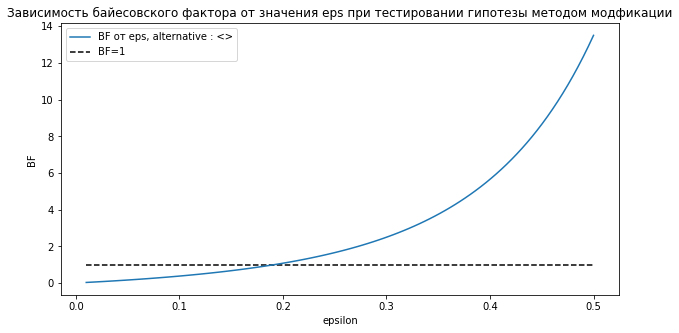

In [94]:
plt.figure(figsize=( 10, 5))

plt.title("Зависимость байесовского фактора от значения eps при тестировании гипотезы методом модфикации")
plt.plot(grid, BF1, label='BF от eps, alternative : <>')
plt.hlines(1, 0.01, 0.5, linestyles='--', label='BF=1')
plt.xlabel("epsilon")
plt.ylabel("BF")

plt.legend()

plt.show()

Уже начиная с $\epsilon \approx 1.9$ байесовский фактор > 1

Еще пример:

$x_1, x_2, .., x_{20} \sim \mathcal{N}(3, 1^2)$

$y_1, y_2, .., y_{30} \sim \mathcal{N}(1, 3^2)$

$H_0 \ : \ \delta = 0 \ vs \ H_1 : \delta > 0$

Априорная вер-ть нулевой гипотезы $\Pi_0 = 0.01$ - то есть априорно считаем что с очень маленькой вероятностью мы получим гипотезу о равенстве средних

In [105]:
Y = sps.norm(1, 3).rvs(20)
X = sps.norm(3, 1).rvs(30)

stat_test = BehrensFisherProblem(alternative='>')

stat_test.test(X, Y, method='modify', eps=0.2, pi0=0.1)

{'BF': 0.04243911143103621,
 'HDR': (0.49791378933807384, 3.0895610490290437),
 'Posterior H0 prob': 0.0046933256511936736,
 'Posterior H1 prob': 0.9953066743488063,
 'posterior_df': 22.26751212370226,
 'posterior_loc': 1.793737419183559,
 'posterior_scale': 0.6252678980682252}

0 не лежит в 95 % HDR, значит гипотеза отвергается

BF << 1, значит  после эксперимента мы гораздо меньше стали верить нулевой гипотезе, по сравнению с априорными предположениями, несмотря на то, что априори мы в нулевую гипотезу почти не верили.

Из вывода нашего теста мы можем верно отвергнуть гипотезу 